# Телеком: прогноз оттока клиентов

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

**Цель исследования** - научиться выявлять клиентов, которые планируют отказаться от услуг компании «ТелеДом», чтобы избежать финансовых потерь. Сохранить старых клиентов дешевле, чем привлечь новых.

**Моя задача** — обучить на этих данных модель для прогноза оттока клиентов, найти признаки-индикаторы оттока клиентов.

*Кратко об услугах компании:*

- Два основных типа услуг: 
    - Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
    - Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
- Дополнительные услуги:
    - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    - Выделенная линия технической поддержки (TechSupport);
    - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
    - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

Получены данные для исследования в нескольких таблицах:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Исследование пройдет в несколько этапов:
1. Обзор данных
2. Предобработка данных
3. Разведочный анализ данных
4. Подготовка данных к МО и подбор модели
5. Итоговый вывод и рекомендации 


# 1.Обзор данных

## 1.1 Информация о договоре

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import phik
import shap
import plotly.express as px

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder , StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest
from optuna_integration import OptunaSearchCV
from optuna.distributions import IntDistribution as intd, FloatDistribution as fl, CategoricalDistribution as CatDist

from datetime import date
from dateutil.relativedelta import relativedelta

%matplotlib inline
RANDOM_STATE = 180324
sns.set_palette("pastel")
pd.set_option('display.max_columns', None)
shap.initjs()

In [1]:
pth_local1 = 'contract_new.csv'
pth_local2 = 'personal_new.csv'
pth_local3 = 'internet_new.csv'
pth_local4 = 'phone_new.csv'

pth1 = '/datasets/contract_new.csv'
pth2 = '/datasets/personal_new.csv'
pth3 = '/datasets/internet_new.csv'
pth4 = '/datasets/phone_new.csv'

if os.path.exists(pth_local1) and os.path.exists(pth_local2) and os.path.exists(pth_local3) and os.path.exists(pth_local4):
    contract = pd.read_csv(pth_local1, parse_dates = ['BeginDate', 'EndDate'], index_col='customerID')
    personal = pd.read_csv(pth_local2, index_col='customerID')
    internet = pd.read_csv(pth_local3, index_col='customerID')
    phone = pd.read_csv(pth_local4, index_col='customerID')
elif os.path.exists(pth1) and os.path.exists(pth2) and os.path.exists(pth3) and os.path.exists(pth4):
    contract = pd.read_csv(pth1, parse_dates = ['BeginDate', 'EndDate'], index_col='customerID')
    personal = pd.read_csv(pth2, index_col='customerID')
    internet = pd.read_csv(pth3,index_col='customerID')
    phone = pd.read_csv(pth4, index_col='customerID')
else:
    print('Something is wrong')

C:\Users\very-\AppData\Local\Temp\ipykernel_5820\858765728.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract = pd.read_csv(pth_local1, parse_dates = ['BeginDate', 'EndDate'], index_col='customerID')


In [2]:
contract.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
6654-QGBZZ,2020-01-01,No,Month-to-month,No,Mailed check,19.90,21.49
6344-SFJVH,2018-06-01,No,Month-to-month,No,Credit card (automatic),24.90,498.0
2533-TIBIX,2018-11-01,No,Month-to-month,Yes,Bank transfer (automatic),30.20,453.0
8752-STIVR,2019-07-01,No,Month-to-month,Yes,Electronic check,79.00,553.0
0257-KXZGU,2017-06-01,No,Month-to-month,No,Bank transfer (automatic),62.45,1998.4


In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


In [4]:
contract.describe(include='all')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,NaN,67,3,2,4,NaN,6658
top,NaN,No,Month-to-month,Yes,Electronic check,NaN,
freq,NaN,5942,3875,4171,2365,NaN,11
mean,2017-04-30 13:01:50.918642688,NaN,NaN,NaN,NaN,64.761692,NaN
min,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,18.250000,NaN
25%,2015-06-01 00:00:00,NaN,NaN,NaN,NaN,35.500000,NaN
50%,2017-09-01 00:00:00,NaN,NaN,NaN,NaN,70.350000,NaN
75%,2019-04-01 00:00:00,NaN,NaN,NaN,NaN,89.850000,NaN
max,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,118.750000,NaN


In [5]:
contract[contract.TotalCharges == ' ']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


In [6]:
contract.TotalCharges.value_counts().head(10)

TotalCharges
          11
20.45      6
101.0      5
21.53      4
40.1       4
255.0      4
19.65      4
732.6      4
1007.5     4
1155.0     3
Name: count, dtype: int64

In [7]:
contract[contract.BeginDate == '2020-02-01']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


### Микровывод:
1. В таблице о договорах предсталена следующая информация
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц  (плановые);
- `TotalCharges` — общие расходы абонента (фактические).
2. Есть пропуски в колонке `TotalCharges` в виде пробелов, а не None. Видимо, эти значения отсутствуют у пользователей оформивших договор только 1 февраля 2020 года. Это дата когда данные для анализа были выгружены и более поздней информации нет. 
3. Тип данных в колонках `BeginDate`, `EndDate` при загрузке изменили на datetime формат.



## 1.2 Персональные данные клиентов

In [8]:
personal.sample(5)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7354-OIJLX,Male,0,No,No
1271-SJBGZ,Male,1,No,No
9522-BNTHX,Female,1,No,No
7980-MHFLQ,Female,0,Yes,Yes
7742-MYPGI,Female,0,Yes,Yes


In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [10]:
personal.describe(include='all')

,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


### Микровывод:
1. В персональных данных есть информация о:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

2. Пропусков снова нет.
3. Каждый признак (кроме идентификатора) в таблице бинарный.

## 1.3 Информация об интернет-услугах

In [11]:
internet.sample(5)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
4837-PZTIC,DSL,Yes,No,Yes,Yes,No,No
8791-GFXLZ,DSL,No,Yes,No,No,No,No
7927-AUXBZ,Fiber optic,No,No,No,Yes,Yes,No
4374-YMUSQ,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
4002-BQWPQ,DSL,Yes,Yes,Yes,Yes,No,Yes


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [13]:
internet.describe(include='all')

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


### Микровывод:
1. Характеристики, описывающие интернет-услуги:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

2. Записей меньше, чем в предыдущих таблицах, т.к. не все клиенты пользуются интернет услугами компании, кого-то интересует только телефонная связь.
3. Все признаки (кроме идентификатора) бинарные.

## 1.4 Услуги телефонии

In [14]:
phone.sample(5)

,MultipleLines
customerID,
3966-HRMZA,No
2860-RANUS,Yes
4423-JWZJN,Yes
6134-KWTBV,Yes
1702-CCFNJ,Yes


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [16]:
phone.describe()

,MultipleLines
count,6361
unique,2
top,No
freq,3390


### Микровывод:
1. Признаки в данной таблице:
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

2. Не все клиенты компании пользуются услугами телефонии.

## 1.5 Вывод по обзору
- Информация представлена в 4 таблицах. Данные соответствуют описанию задачи.
- Всего для исследования предоставлены данные 7043 клиентов компании, некоторые пользуются только интернет услугами, другие - услугами телефонии.
- Есть клиенты, которые только начали пользоваться услугами компании - договор от 1 февраля 2020 (дата выгрузки данных).

# 2. Предобработка данных
## 2.1 Пропуски

Есть небольшое число пропусков в таблице `contract` в колонке `TotalCharges`.

Пропуски характерные для клиентов, которые только пришли в компанию и еще ничего не заплатили. Поэтому поставим 0 на месте пропусков.

In [17]:
contract['TotalCharges'] = contract['TotalCharges'].apply(lambda x: 0 if x == ' ' else x)

In [18]:
contract[contract.TotalCharges == 0]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0


## 2.2 Дубликаты 

- дубликаты строк

In [19]:
tables = [contract, personal, internet, phone]

In [20]:
for table in tables:
    print(table.duplicated().sum())

37
7027
5389
6359


Дубликатов ID нет, строки без ID в таблицах повторяются, но это нормально, т.к. данные приведенные в таблицах не слишком индивидуальны и могут быть одинаковыми для разных клиентов.

- проверим наличие ошибок в названиях категорий типов оплаты и типов платежей (остальные категоиральные признаки бинарные, видели в обзоре, там ошибок точно нет)

In [21]:
print('Значения типов оплаты по договору:')
print(tables[0].Type.value_counts())

print('Значения типов платежей:')
print(tables[0].PaymentMethod.value_counts())

Значения типов оплаты по договору:
Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
Значения типов платежей:
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


## 2.3 Изменение типов данных и добавление признаков

**Даты (начало и конец периода обслуживания клиента):**

- Добавим дату выгрузки данных в столбец `EndDate_all` неушедших пользователей и перенесем соответствующую дату для ушедших. Затем в столбцы с длительностью (по месяцам, дням, годам) добавим инфо про неушедших клиентов.

- Добавим признаки: длительность договора в годах, в днях и в месяцах для всех клиентов,для ушедших - это окончательное число, для нынешних - длительность пользования на момент выгрузки данных.

In [22]:
contract.BeginDate.value_counts().head()

BeginDate
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
Name: count, dtype: int64

In [23]:
contract.EndDate.value_counts().head()

EndDate
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
Name: count, dtype: int64

In [24]:
contract['EndDate_all'] = contract['EndDate'].apply(lambda x: x if x!='No' else '2020-02-01')
contract['EndDate_all'] = pd.to_datetime(contract['EndDate_all']).dt.date
contract['BeginDate'] = pd.to_datetime(contract['BeginDate']).dt.date


In [25]:
def calculate_year_difference(row):
    '''
    Функция принимает ряд датасета и вычисляет разницу между датой начала контракта и конца контракта в годах 
    '''
    return relativedelta(row['EndDate_all'], row['BeginDate']).years

    
def calculate_month_difference(row):
    '''
    Функция принимает ряд датасета и вычисляет разницу между датой начала контракта и конца контракта в месяцах e
    '''
    return (relativedelta(row['EndDate_all'], row['BeginDate']).years * 12) + relativedelta(row['EndDate_all'], row['BeginDate']).months

    
def calculate_day_difference(row):
    '''
    Функция принимает ряд датасета и вычисляет разницу (количество дней) между датой начала контракта и конца контракта 
    '''
    return (row['EndDate_all'] - row['BeginDate']).days
    
contract['year_duration'] = (contract.apply(calculate_year_difference, axis=1)).astype('object')
contract['month_duration'] = contract.apply(calculate_month_difference, axis=1)
contract['day_duration'] = contract.apply(calculate_day_difference, axis=1)


In [26]:
contract.sample(15)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_all,year_duration,month_duration,day_duration
customerID,,,,,,,,,,,
1635-FJFCC,2019-09-01,No,Month-to-month,Yes,Credit card (automatic),44.05,220.25,2020-02-01,0,5,153
4662-EKDPQ,2019-08-01,No,Month-to-month,No,Bank transfer (automatic),62.05,390.91,2020-02-01,0,6,184
7880-XSOJX,2019-10-01,No,Month-to-month,No,Mailed check,42.40,186.56,2020-02-01,0,4,123
8046-DNVTL,2014-12-01,2017-07-01,Two year,Yes,Credit card (automatic),38.60,1292.33,2017-07-01,2,31,943
5092-STPKP,2018-02-01,No,Month-to-month,No,Credit card (automatic),56.35,1365.92,2020-02-01,2,24,730
9938-ZREHM,2017-01-01,No,One year,No,Mailed check,72.10,2881.12,2020-02-01,3,37,1126
6196-HBOBZ,2014-09-01,No,Two year,Yes,Electronic check,99.35,6457.75,2020-02-01,5,65,1979
9668-PUGNU,2014-03-01,No,Two year,Yes,Electronic check,24.50,1861.27,2020-02-01,5,71,2163
1976-CFOCS,2019-12-01,No,Month-to-month,No,Electronic check,46.00,99.36,2020-02-01,0,2,62


- остальные

In [27]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('object')

print(personal.info())

personal.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   object
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: object(4)
memory usage: 275.1+ KB
None


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [28]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

print(contract.info())
contract.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   EndDate_all       7043 non-null   object 
 8   year_duration     7043 non-null   object 
 9   month_duration    7043 non-null   int64  
 10  day_duration      7043 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 660.3+ KB
None


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_all,year_duration,month_duration,day_duration
customerID,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,2020-02-01,0,1,31
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,2020-02-01,2,34,1036
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,2020-02-01,0,4,123
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,2020-02-01,3,45,1371
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,2020-02-01,0,5,153


## 2.4 Целевой признак - факт оттока

Мне предстоит решать задачу классификации, но в данных нет соответсвующей переменной (ушел клиент или нет). Добавлю этот признак на основании наличия даты ухода `EndDate`.

In [29]:
contract['left'] = (contract['EndDate'].apply(lambda x: 0 if x =='No' else 1)).astype('object')

In [30]:
contract['left'].value_counts()

left
0    5942
1    1101
Name: count, dtype: int64

## 2.5 Вывод по предобработке
1. Обнаружено небольшое количество пропусков в таблице с контрактами в колонке общих расходов.Пропуски характерные для клиентов, которые только оформили договор и еще ничего не заплатили. Таких записей 11 штук. Пропуски преобразовали в 0.
2. Дубликатов не обнаружено.
3. Изменила тип данных колонки, является ли клиент пенсионером, - на категориальный тип; колонки общих расходов - на вещественный числовой.
4. Добавила целевой признак (1 - клиент ушел, 0 - клиент остался), а также вспомогателные признаки с длительностью контракта (в годах,в днях и в месяцах) для всех клиентов.

# 3. Разведочный анализ данных

## 3.1 **Количественные данные**

Количественные данные есть только в таблице с контрактами (месячные и годовые расходы, длительность контрактов)

In [31]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def hist_and_box_for_nums_plotly(data, cols):
    rows = len(cols) 
    fig = make_subplots(rows=rows, cols=2, subplot_titles=list(np.concatenate([[f'Распределение: {col}' , f'Разброс значений: {col}'] for col in cols] )))
    for i, col in enumerate(cols):
        fig.add_trace(
            go.Histogram(x=data[col], nbinsx=50,  name=col), 
            row=i+1, col=1)
        fig.add_trace(
            go.Box(y=data[col], name=col), 
            row=i+1, col=2
        )
    fig.update_layout(height=400*rows, title_text='Распределение и разброс значений признаков', title_x=0.5, showlegend = False)
    fig.update_yaxes(title_text="Число клиентов", col=1)
    fig.update_xaxes(title_text="Значение признака", col=1)
    fig.update_yaxes(title_text="Значение признака", col=2)
    
    fig.show()

In [32]:
num_cols = contract.drop([ 'left'], axis=1).select_dtypes(include='number').columns 
hist_and_box_for_nums_plotly(contract, num_cols)

In [33]:
def hist_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.histplot(data = data[col], bins = 50, ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Число клиентов')
def box_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.boxplot(data = data[col].values, ax=ax)
        ax.set_title(col)
        ax.set_ylabel(col)

- Большинство имеют минимальные месячные и общие расходы. Вероятно пользуются одной или небольшим количеством услуг. 
- Особенно для общих расходов характерно: чем больше расходы, тем меньше таких клиентов. Это постоянные долгосрочные клиенты.

- Много относительно новых клиентов - в компании около 10-20 недель. Есть локальный максимум "старых" клиентов - пользуются услугами компании около 70 месяцев (более пяти лет).

## 3.2 **Даты**

Посмотрим за какой период данные. 

In [34]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Приток клиентов по годам', 'Приток клиентов по месяцам, только 2019 г'])
fig.add_trace(go.Bar(x=pd.DatetimeIndex(contract['BeginDate']).year.value_counts().index, y=pd.DatetimeIndex(contract['BeginDate']).year.value_counts().values), row=1, col=1)
fig.add_trace(go.Bar(x=contract[pd.DatetimeIndex(contract['BeginDate']).year == 2019].BeginDate.value_counts().index, 
                     y=contract[pd.DatetimeIndex(contract['BeginDate']).year == 2019].BeginDate.value_counts().values), row=1, col=2)
fig.update_layout({'title': {'text':"Распределение притока клиента по времени", 'x':0.5}}, showlegend=False)
fig.update_yaxes(title_text = 'Число клиентов')
fig.update_xaxes(title_text='Год', row=1, col=1)
fig.update_xaxes(title_text='Месяц', row=1, col=2)


Работаем с данными по клиентам которые пришли в компанию с 2013 по 2020 годы. При этом больше всего клиентов пришло в 2019 и 2014 году.

Если отдельно рассмотреть ушедших клиентов, то увидим, что:
- большая из часть стала клиентами компании в 2014-2015 гг
- покидали компанию в основном в 2018-2019 гг и в основном после 1-3 лет пользования услушами компании

In [35]:
contracts_left = contract[contract['left'] == 1]
fig = make_subplots(rows=1, cols=3, subplot_titles=['Приток клиентов по годам, только среди ушедших', 'Отток клиентов по годам', 'Длительность контрактов ушедших клиентов'])
fig.add_trace(go.Bar(x=pd.DatetimeIndex(contracts_left['BeginDate']).year.value_counts().index, y=pd.DatetimeIndex(contracts_left['BeginDate']).year.value_counts().values), row=1, col=1)
fig.add_trace(go.Bar(x=pd.DatetimeIndex(contracts_left['EndDate_all']).year.value_counts().index, 
                     y=pd.DatetimeIndex(contracts_left['EndDate_all']).year.value_counts().values), row=1, col=2)
fig.add_trace(go.Bar(x=contracts_left['year_duration'].value_counts().index, 
                     y=contracts_left['year_duration'].value_counts().values), row=1, col=3)
fig.update_layout({'title': {'text':"Информация об оттоке клиентов", 'x':0.5}}, showlegend=False)
fig.update_yaxes(title_text = 'Число клиентов')

fig.update_xaxes(title_text='Год начала', row=1, col=1)
fig.update_xaxes(title_text='Год окончания', row=1, col=2)
fig.update_xaxes(title_text='Длительность, лет', row=1, col=3)

## 3.3 **Категориальные признаки**

In [36]:
def count_for_cat(data, columns, cols_subplots=2):
    cols_subplots = cols_subplots
    rows = (len(columns) + cols_subplots - 1) // cols_subplots
    fig = make_subplots(rows=rows, cols=cols_subplots, subplot_titles=[f'Распределение: {col}' for col in columns])
    for i, col in enumerate(columns):
        row = (i // cols_subplots) + 1  
        colmn = (i % cols_subplots) + 1
        fig.add_trace(go.Bar(x=(data[col].value_counts(normalize=True)*100).index, y=(data[col].value_counts(normalize=True)*100).values), row=row, col=colmn)

    fig.update_layout(height=400*rows,title_text='Распределение категориальных признаков', title_x=0.5, showlegend = False)
    fig.update_yaxes(title_text="Доля клиентов, %")
    fig.update_xaxes(title_text="Значение признака")
    if 'left' in columns:
        fig.update_xaxes(tickvals=["0", "1"],ticktext=["No", "Yes"], row=2, col=2)
    if 'SeniorCitizen' in columns:
        fig.update_xaxes(tickvals=["0", "1"],ticktext=["No", "Yes"], row=1, col=2)
    if 'InternetService' in columns:
        fig.update_xaxes(tickvals=["No", "Yes"],ticktext=["Not applied", "Applied"])
        fig.update_xaxes(tickvals=(data['InternetService'].value_counts(normalize=True)*100).index, ticktext= (data['InternetService'].value_counts(normalize=True)*100).index,  row=1,col=1)


    fig.show()


In [37]:
cat_cols = contract.drop(['EndDate', 'BeginDate', 'EndDate_all', 'year_duration' ], axis=1).select_dtypes(exclude='number').columns 
count_for_cat(contract, cat_cols)

- Большинство клиентов оплачивает услуги компании ежемесячно. 
- Чуть больше половины клиентов получают электронный расчетный лист и с помощью него оплачивают услуги. У 44% клиентов подкючен автоплатеж.

- В датасете присутствует дисбаланс по целевому классу: только 16% от всех клиентов перестали пользоваться услугами компании.

In [38]:
personal.sample()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
5708-EVONK,Female,0,Yes,Yes


In [39]:
cat_cols = personal.select_dtypes(exclude='number').columns 
count_for_cat(personal, cat_cols)


- Среди клиентов равное количество мужчин и женщин, в браке и нет.
- Клиенты, в основном, не являются пенсионерами и не имеют детей.


In [40]:
phone.sample()

,MultipleLines
customerID,
1697-NVVGY,No


In [41]:
internet.sample()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
4636-JGAAI,Fiber optic,No,Yes,No,No,No,Yes


In [42]:
cat_cols = internet.select_dtypes(exclude='number').columns 

count_for_cat(internet, cat_cols, cols_subplots=3)


In [43]:
cat_cols = phone.select_dtypes(exclude='number').columns 

count_for_cat(phone, cat_cols, cols_subplots=1)

Касаемо подключенных услуг:
- около 60% клиентов подключили интернет через оптоволокно
- клиенты довольно активно пользуются дополнительными интрнет-услугами. Примерно 40% клиентов пользуются той или иной услугой (антивирус, облако, блокировка опасных сайтов, вип поддержка). Примерно половина клиентов подключило стриминговое тв или католог фильмов.
- Почти половина клиентов имеет подключение к нескольким телефонным линиям одновременно

## 3.4 Вывод по EDA

1. Для работы предоставлены данные по клиентам которые пришли в компанию с 2013 по 2020 годы. При этом больше всего клиентов пришло в 2019 и 2014 году.
2. Много относительно новых клиентов - в компании около 10-20 недель. Есть локальный максимум "старых" клиентов - пользуются услугами компании около 70 месяцев (более пяти лет).

3. "Усредненного" клиента можно описать так:
    - небольшое количество подключенных услуг, отсюда небольшие месячные расходы
    - оплачивает услуги компании ежемесячно, оплата по электронному расчетному листу или подключен автоплатеж
    - моложе пенсионного возраста, без детей
    - если пользуется интернет услугами, то подключение через оптоволокно, вероятно подключены доп услуги (стриминговое ТВ и  др).

4. В датасете присутствует дисбаланс по целевому классу: только 16% от всех клиентов перестали пользоваться услугами компании. Это умеренный дисбаланс, ничего предпринимать для его устранения не будем (кроме того, что учтем это при разбиении выборок).

5. Если отдельно рассмотреть ушедших клиентов, то увидим, что:
- большая их часть стала клиентами компании в 2014-2015 гг
- покидали компанию в основном в 2018-2019 гг
- разрывали контракт после 1-3 лет пользования услугами оператора



# 4. Объединение таблиц и анализ общей таблицы

## 4.1 Объединение

In [44]:
total = personal.merge(contract, on = 'customerID', how = 'inner').merge(internet, on = 'customerID', how = 'left').merge(phone, on = 'customerID', how = 'left')
total.shape

(7043, 24)

In [45]:
total.sample(3)

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_all,year_duration,month_duration,day_duration,left,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,,,,
8849-PRIQJ,Female,0,Yes,Yes,2014-07-01,2016-06-01,One year,Yes,Electronic check,109.40,2516.2,2016-06-01,1,23,701,1,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes
5244-IRFIH,Male,1,Yes,No,2017-01-01,No,Month-to-month,Yes,Electronic check,94.50,3496.5,2020-02-01,3,37,1126,0,Fiber optic,No,No,No,No,Yes,Yes,Yes
4412-YLTKF,Female,1,No,No,2017-10-01,No,Month-to-month,Yes,Electronic check,78.05,2185.4,2020-02-01,2,28,853,0,Fiber optic,No,No,Yes,No,No,No,Yes


In [46]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   BeginDate         7043 non-null   object 
 5   EndDate           7043 non-null   object 
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   float64
 11  EndDate_all       7043 non-null   object 
 12  year_duration     7043 non-null   object 
 13  month_duration    7043 non-null   int64  
 14  day_duration      7043 non-null   int64  
 15  left              7043 non-null   object 
 16  InternetService   5517 non-null 

Объединенная таблица готова, все 7043 клиента на месте. 

Заменим пропуски специальной категорией,у тех кто пользуется только интрнетом или только телефоном от оператора.

In [47]:
total.MultipleLines = total.MultipleLines.fillna('NO_phone')

int_col = [internet.columns]

for col in int_col:
    total[col]= total[col].fillna('NO_internet')

In [48]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   BeginDate         7043 non-null   object 
 5   EndDate           7043 non-null   object 
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   float64
 11  EndDate_all       7043 non-null   object 
 12  year_duration     7043 non-null   object 
 13  month_duration    7043 non-null   int64  
 14  day_duration      7043 non-null   int64  
 15  left              7043 non-null   object 
 16  InternetService   7043 non-null 

## 4.2 Разведочный анализ с делением по целевому признаку
- количественные показатели

In [49]:
num_cols = total.select_dtypes(include='number').columns
num_cols

Index(['MonthlyCharges', 'TotalCharges', 'month_duration', 'day_duration'], dtype='object')

In [50]:
def hist_for_classes_plotly(df, col, bins=50):

    class_0 = df[df['left'] == 0][col]
    class_1 = df[df['left'] == 1][col]
    

    trace1 = go.Histogram(x=class_1, nbinsx=bins, name='ушли', opacity=0.75, histnorm='probability density')
    trace2 = go.Histogram(x=class_0, nbinsx=bins, name='остались', opacity=0.75, histnorm='probability density')
    
    fig = go.Figure(data=[trace1, trace2])
    
    fig.update_layout(title_text=col, title_x=0.5,
                      xaxis_title_text=col,
                      yaxis_title_text='Плотность', 
                      barmode='overlay') 
    fig.update_traces(opacity=0.6)
    
    fig.show()

In [51]:
hist_for_classes_plotly(total,'MonthlyCharges')

In [52]:
hist_for_classes_plotly(total, 'TotalCharges')

Расходы ушедших клиентов слегка выше, чем у оставшихся. Вероятно из-за того, что среди не расторгнувших договор достаточно много новых клиентов, которые пришли меньше года назад.

- категориальные признаки

In [53]:
def count_for_classes(data, columns, cols_subplots=2):
    cols_subplots = cols_subplots
    rows = (len(columns) + cols_subplots - 1) // cols_subplots
    fig = make_subplots(rows=rows, cols=cols_subplots, subplot_titles=[f'Распределение: {col}' for col in columns])
    for i, col in enumerate(columns):
        row = (i // cols_subplots) + 1  
        colmn = (i % cols_subplots) + 1

        colors = {0:'steelblue',
          1:'firebrick'}
        if i==0:
          for t in data['left'].unique():
            dfp = data[data['left']==t]
            fig.add_trace(go.Bar(x=(dfp[col].value_counts(normalize=True)*100).index, y=(dfp[col].value_counts(normalize=True)*100).values, name = 'ушли' if t == 1 else 'остались',
                          marker_color=colors[t]), row=row, col=colmn)
        else:
           for t in data['left'].unique():
            dfp = data[data['left']==t]
            fig.add_trace(go.Bar(x=(dfp[col].value_counts(normalize=True)*100).index, y=(dfp[col].value_counts(normalize=True)*100).values,name=t,
                          marker_color=colors[t], showlegend=False), row=row, col=colmn)
            
        if col == 'SeniorCitizen':
          fig.update_xaxes(tickvals=["0", "1"],ticktext=["No", "Yes"], row=row, col=colmn)
        if col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']:
          fig.update_xaxes(tickvals=["No", "Yes", 'NO_internet'],ticktext=["Not applied", "Applied", 'no internet service'], row=row, col=colmn)
        if col == 'MultipleLines':
          fig.update_xaxes(tickvals=["No", "Yes", 'NO_phone'],ticktext=["Not applied", "Applied", 'no phone service'], row=row, col=colmn)
           

    fig.update_layout(height=400*rows,title_text='Распределение категориальных признаков в классах', title_x=0.5, showlegend = True)
    fig.update_yaxes(title_text="Доля клиентов, %")
    fig.update_xaxes(title_text="Значение признака")
    fig.update_xaxes(title_text="Длительность контракта, лет", row=4, col=2)

    fig.show()

In [54]:
cat_cols = total.drop(['left', 'BeginDate', 'EndDate', 'EndDate_all'], axis=1).select_dtypes(exclude='number').columns

count_for_classes(total, cat_cols)

In [55]:
fig = go.Figure()
colors = {0:'steelblue',
          1:'firebrick'}
for t in total['left'].unique():
    dfp = total[total['left']==t]
    fig.add_trace(go.Bar(x=(pd.DatetimeIndex(dfp['BeginDate']).year.value_counts(normalize=True)*100).index, y=(pd.DatetimeIndex(dfp['BeginDate']).year.value_counts(normalize=True)*100).values, name = 'ушли' if t == 1 else 'остались',
                        marker_color=colors[t]))
fig.update_layout(title_text='Год оформления договора в классах', title_x=0.5, showlegend = True)
fig.update_yaxes(title_text="Доля клиентов, %")
fig.update_xaxes(title_text="год")
fig.show()

Различия "портретов" ушедшего клиента и оставшегося клиента компании:
- Более половины ушедших клиентов состоят в браке ( среди оставшихся - больше одиноких) 
- Ушедшие клиенты относительно меньше пользовались расчетом по почте нежеди действующие клиенты.
- Ушедшие клиенты активнее пользовались доп интернет услугами (облако, антивирус, стриминговое тв, каталог фильмов)
- Ушедшие клиенты активнее пользовались услугой подключения нескольких телефонных линий

Ушли, в основном, старые клиенты.

Среди оставшихся клиентов много новых , которые пришли около года назад или меньше.

## 4.3 Корреляции признаков

In [56]:
corr_matrix1 = total.drop(columns=['BeginDate', 'EndDate', 'EndDate_all']) \
.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'month_duration', 'day_duration'])

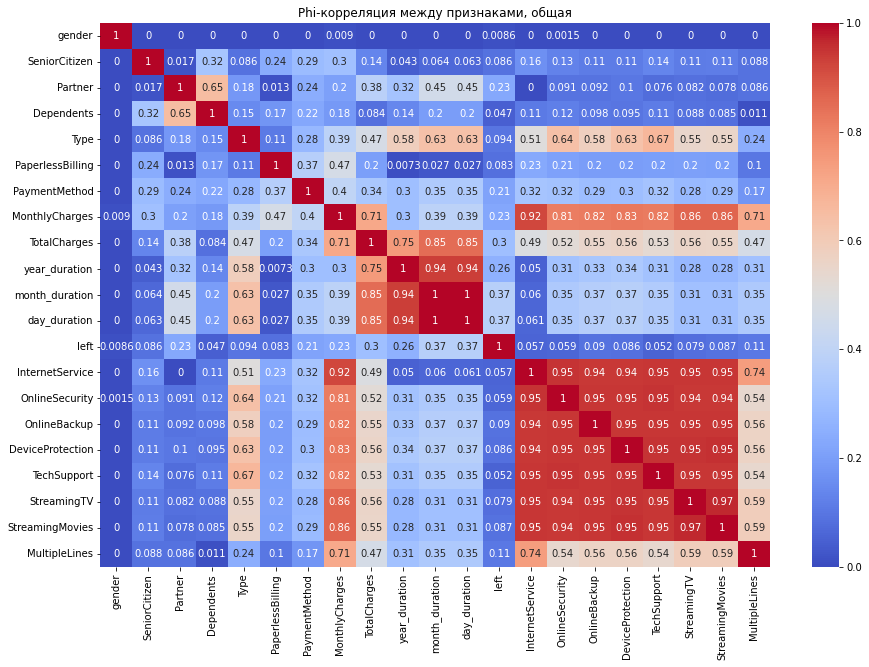

In [57]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title('Phi-корреляция между признаками, общая')
plt.show();

С целевым признаком остальные признаки коррелируют умеренно или слабо. 

C:\Users\very-\AppData\Roaming\Python\Python39\site-packages\phik\data_quality.py:82: UserWarning:

Not enough unique value for variable left for analysis 1. Dropping this column



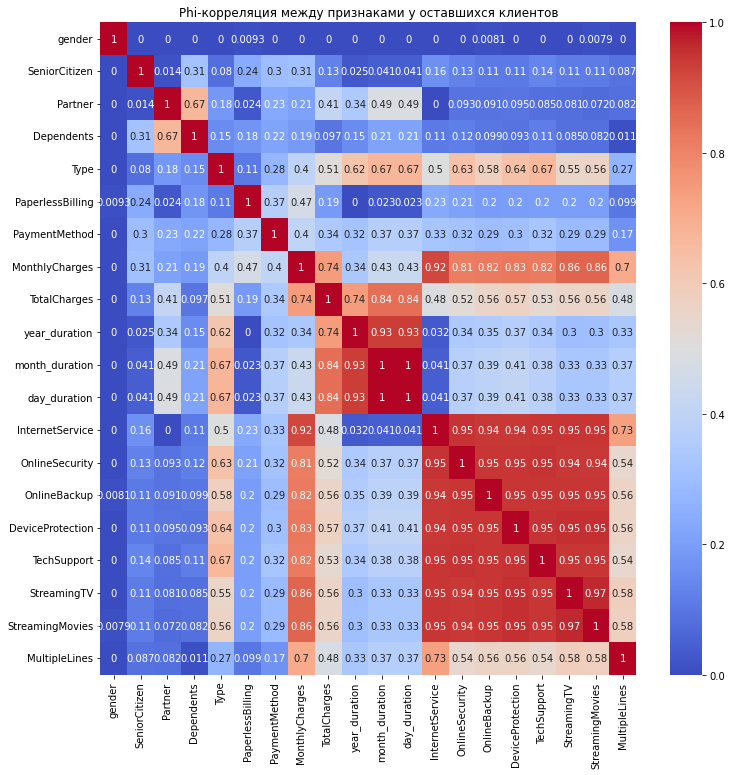

In [58]:
corr_matrix = total[total['left']==0].drop(columns=['BeginDate', 'EndDate', 'EndDate_all']) \
.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'month_duration', 'day_duration'])

plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi-корреляция между признаками у оставшихся клиентов')
plt.show();


В подгруппе оставшихся клиентов:

- Все интернет услуги сильно коррелируют друг с другом - мультиколлинеарны.

- Длительность договора в днях и месяцах тоже мультиколлинеарны, очевидно

- Пол клиента никак не связан с остальными признаками (стоит убрать из исследования).

- Расходы коррелируют с наличием подключенных услуг: очевидно, чем больше подключено услуг, тем больше расходы клиента.

In [59]:
total.sample()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_all,year_duration,month_duration,day_duration,left,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,,,,
1644-IRKSF,Female,0,Yes,Yes,2017-01-01,2018-05-01,One year,Yes,Electronic check,93.8,1635.87,2018-05-01,1,16,485,1,Fiber optic,No,No,Yes,No,Yes,Yes,No


C:\Users\very-\AppData\Roaming\Python\Python39\site-packages\phik\data_quality.py:82: UserWarning:

Not enough unique value for variable left for analysis 1. Dropping this column



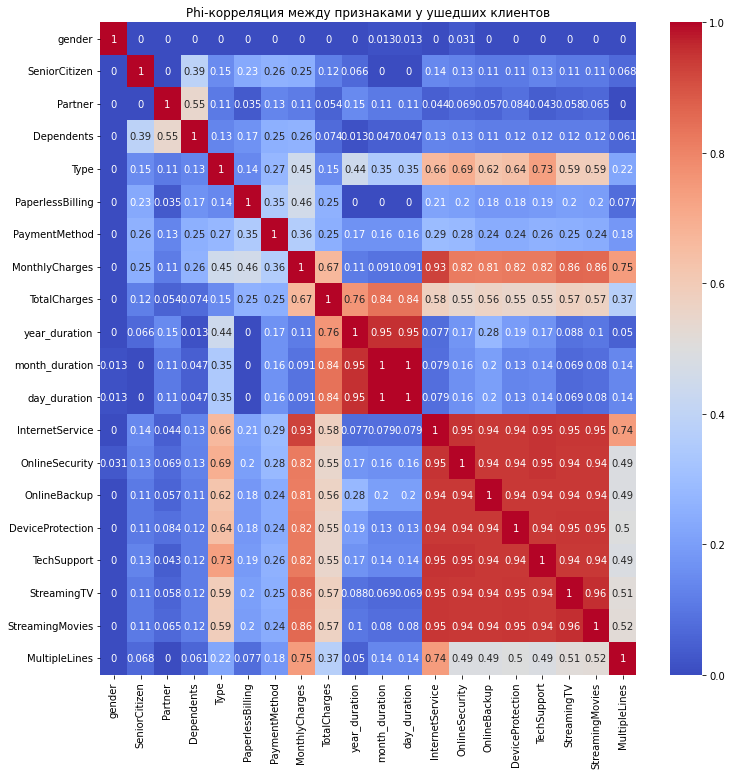

In [60]:
corr_matrix1 = total[total['left']==1].drop(columns=['BeginDate', 'EndDate', 'EndDate_all']) \
.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'month_duration', 'day_duration'])
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title('Phi-корреляция между признаками у ушедших клиентов')
plt.show();

Для класса ушедших клиентов характерны все выше описанные закономерности для первого класса.

## 4.4 Вывод 
1. Все четыре таблицы соединили в одну.

2. Проанализировали данные по группам (ушел / не ушел клиент):

- Расходы ушедших клиентов слегка выше, чем у оставшихся. Вероятно из-за того, что среди не расторгнувших договор достаточно много новых клиентов, которые пришли меньше года назад.
- Различия "портретов" ушедшего клиента и оставшегося клиента компании:
    - Более половины ушедших клиентов состоят в браке ( среди оставшихся - больше одиноких) 
    - Ушедшие клиенты относительно меньше пользовались расчетом по почте нежеди действующие клиенты.
    - Ушедшие клиенты активнее пользовались доп интернет услугами (облако, антивирус, стриминговое тв, каталог фильмов)
    - Ушедшие клиенты активнее пользовались услугой подключения нескольких телефонных линий

- Ушли, в основном, старые клиенты.

- Среди оставшихся клиентов много новых , которые пришли около года назад или меньше.

3. Корреляции:
- С целевым признаком остальные признаки коррелируют слабо. 
- Все интернет услуги сильно коррелируют друг с другом - мультиколлинеарны.
- Пол клиента никак не связан с остальными признаками (стоит убрать дальше из исследования).
- Расходы коррелируют с наличием подключенных услуг: очевидно, чем больше подключено услуг, тем больше расходы клиента.


# 5. Подготовка данных и обучение моделей

Необходимо решить задачу классификации.

Таргет - признак `left`, ушел клиент или остался.

В качестве входных признаков будем использовать не все. Уберем даты, пол клиента. 

При подготовке данных для линейной модели уберем все мультиколлинеарные признаки (из всех интернет услуг оставим только `InternetService`).

Количественные данные масштабируем с помощью StandardScaler. 
Для категориальных признаков применим OHE для не "деревянных" моделей. Для моделей в основе которых лежат деревья - OrdinalEncoder.

Будем работать через пайплайны.

Оценим качество разбиения на классы с помощью ROC-AUC для классификаторов логистической регрессии, дерева решений, SVC, KNN, lightgbm и выберем лучшую (самую точную) модель. 

**Критерий успеха: ROC-AUC ≥0.85 на тестовой выборке.** Дополнительно будем использовать accuracy для удобства интерпретации точности модели.

## 5.1 Базовая модель - логистическая регрессия

In [61]:
total['year_duration'] = total['year_duration'].astype(int)
drop_cols = ['gender', 'BeginDate', 'EndDate','EndDate_all', 'left', 'month_duration',
             'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

total['left'] = total['left'].astype(int)

X = total.drop(columns = drop_cols)
y = total.left
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=RANDOM_STATE)

In [62]:
X_train.shape

(5282, 12)

In [63]:
num_columns = X.select_dtypes(include='number').columns
ohe_columns = X.select_dtypes(exclude='number').columns
print(num_columns)
print(ohe_columns)

Index(['MonthlyCharges', 'TotalCharges', 'year_duration', 'day_duration'], dtype='object')
Index(['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'InternetService', 'MultipleLines'],
      dtype='object')


In [64]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [65]:
pipe_final = Pipeline(
    [   ('preprocessor', data_preprocessor),
     ('selection', SelectKBest(k = 10)),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [66]:
pipe_final.fit(X_train, y_train)

print(f'Roc-Auc модели: {cross_val_score(pipe_final,X_train, y_train, cv =StratifiedKFold(), scoring = "roc_auc" ).mean()}')

print(f'Точность модели: {cross_val_score(pipe_final,X_train, y_train, cv =StratifiedKFold(), scoring = "accuracy" ).mean()}')

Roc-Auc модели: 0.7220519511583591
Точность модели: 0.8436199148533585


Хороший результат для базовой логистической регрессии!

## 5.2 Подбор лучшей модели


Попробуем улучшить линейную модель:

In [67]:
param_distributions = {'models__C': fl(0.1, 2.0, 0.1),
                       'selection__k': intd(5,15),
        'preprocessor__num': CatDist((StandardScaler(), MinMaxScaler(), 'passthrough'))} 

optuna_search = OptunaSearchCV(
pipe_final, 
param_distributions=param_distributions, 
scoring='roc_auc', 
random_state=RANDOM_STATE,
cv=StratifiedKFold(),
n_jobs=-1,
)
optuna_search.fit(X_train, y_train) 

print('Метрика для лучшей модели:\n', round(optuna_search.best_score_,4))
print('\nЛучшая модель и её параметры:\n\n', optuna_search.best_estimator_) 

c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.

c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.

C:\Users\very-\AppData\Local\Temp\ipykernel_5820\1690458602.py:5: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2024-04-12 16:31:10,773] A new study created in memory with name: no-name-785d0e99-d59f-402e-9493-6f78389a608e


c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Метрика для лучшей модели:
 0.7661

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'InternetService', 'MultipleLines'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['MonthlyCharges', 'TotalCharges', 'year_duration', 'day_duration'], dtype='object'))])),
                ('selection', SelectKBest(k=13)),
                ('models',
                 LogisticRegression(C=0.257219870271167, random_state=180324))])


Качество слегка улучшилось. Попробуем с другими моделями.

Будем варьировать как модели, так и используемые для обучение признаки, чтобы добиться лучшей метрики.

Чтобы легко менять используемые в обучении признаки, создадим функцию для подготовки данных и обучения.

In [68]:
def prepare_n_learn(data, drop_columns,param_distributions):
    '''
    Функция принимает на вход исходный датасет, список признаков для удаления (включая таргет и ID), 
    гиперпараметры для подбора модели в виде списка словарей. 
    Сначала выделяется таргет и входные признаки, 
    затем выборка делится на трейн и тест. \Затем происходит кодировка таргета, кодировка признаков в пайплайне. 
    Формируетмя итоговый пайплайн для обучения.
    Возвращает качество ROC-AUC, параметры лучшей модели после подбора гиперпараметров в ходе RandomizedSearchCV и тестовые выборки
    '''
    y = data.left
    X = data.drop(columns = drop_columns)
    num_columns = X.select_dtypes(include ='number').columns
    cat_columns = X.select_dtypes(exclude ='number').columns

    X[cat_columns] = X[cat_columns].astype('category')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=RANDOM_STATE)

    data_preprocessor = ColumnTransformer(
    [
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
    )

    pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('selection', SelectKBest(k = 19)),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
    )
    

    randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    cv=StratifiedKFold(),
    n_jobs=-1,
    n_iter = 50
    )
    randomized_search.fit(X_train, y_train) 

    return round(randomized_search.best_score_,4), randomized_search.best_estimator_, X_test, y_test

In [69]:
drop_columns = [ 'gender', 'BeginDate', 'EndDate','EndDate_all', 'left', 'month_duration', 'day_duration']
ord_pipe = Pipeline([(
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'imputer_after', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )])

param_distributions = [
    
        {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'preprocessor__cat': [ord_pipe],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'selection__k': range(15,20), 
        } ,

        {'models': [lgb.LGBMClassifier(random_state=RANDOM_STATE)],
        'models__learning_rate': np.arange(0.01, 0.3, 0.02),
        'models__max_depth': range(2,4),
        'models__n_estimators': range(80,160, 20) ,
        'preprocessor__cat': [ord_pipe],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'selection__k': range(15,20), 
        } ,

        {'models': [KNeighborsClassifier()],
         'models__n_neighbors': range(3, 20),
         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
          'selection__k': range(15,20), 
          },

        {'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['rbf', 'poly', 'sigmoid'],
        'models__degree': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
         'selection__k': range(15,20), 
         }
        
    ]

best_score, best_model, X_test, y_test = prepare_n_learn(total, drop_columns,param_distributions)

print('Метрика для лучшей модели:\n', best_score)
print('\nЛучшая модель и её параметры:\n\n', best_model) 


[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
Метрика для лучшей модели:
 0.8324

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                     

Получилось улучшить метрику. Однако пока она все еще не соответствует критерию качества.

Может быть длительность контракта в годах недостаточно информативна? Попробуем добавить длительность в днях и месяцах.

In [70]:
drop_columns = [ 'gender', 'BeginDate', 'EndDate','EndDate_all', 'left',]

best_score, best_model, X_test, y_test = prepare_n_learn(total, drop_columns,param_distributions)

[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [71]:
print('Метрика для лучшей модели:\n', best_score)
print('\nЛучшая модель и её параметры:\n\n', best_model) 

Метрика для лучшей модели:
 0.882

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'InternetServi...
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'],
      dtype='object')),

Добавление длительности контракта в днях и месяцах помогло. Метрика ROC-AUC сильно увеличилась и полученная модель соответсвует критерию качества.

**Лучшая модель LGBMClassifier со скоростью обучения 0.25,  глубиной деревьев 3, 140 моделями в ансамбле.**

Посмотрим качество на тестовой выборке:

In [72]:
print(f'ROC-AUC на тесте: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1] )}')
print(f'Точность на тесте: {accuracy_score(y_test,  best_model.predict(X_test))}')

ROC-AUC на тесте: 0.8993686528814387
Точность на тесте: 0.8932424758659853


Хорошее, походящее под критерий значение метрики ROC-AUC на тестовой выборке!

Точность (accuracy) тоже довольно высокое. Значение 0.9 показывает, что 9 из 10 клиентов модель классифицирует верно.

#### **Посмотрим на матрицу ошибок:**

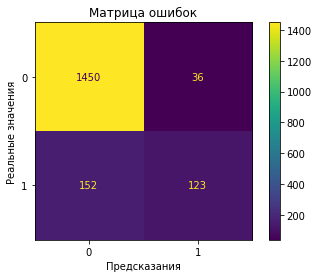

In [73]:
cm = confusion_matrix(y_test, best_model.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=best_model['models'].classes_).plot()
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Реальные значения')
plt.show()

- Из 1603 клиентов оставшихся у оператора  модель правильно предсказала класс 1454 клиентов, а 149 клиентов модель неверно отнесла к классу ушедших.
- Из 158 клиентов ушедших от оператора модель правильно предсказала класс 126 клиентов, а 32 клиентов модель неверно отнесла к классу оставшихся.
- Precision равен 80%: С вероятность 20% модель дает ложноположителный результат - то есть ошибется и предскажет что клиент уходит, хотя он не собирался.
- Recall равен 46 %: Модель в половине случаев может ошибаться и неверно относить собирающегося разорвать договор клиента к классу лояльных клиентов.


#### Проверим модель на **адекватность** с помощью DummyClassifier:

In [74]:
drop_columns

['gender', 'BeginDate', 'EndDate', 'EndDate_all', 'left']

In [75]:
X = total.drop(columns = drop_columns)
y = total.left

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=RANDOM_STATE)

pipe_dummy = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DummyClassifier(strategy="prior"))
    ]
)


In [76]:
pipe_dummy.fit(X_train, y_train)

roc_auc_score(y_test, pipe_dummy.predict_proba(X_test)[:, 1])

0.5

Значение ROC-AUC DummyClassifier хуже, чем в лучшем классификаторе. 

## 5.4 Анализ важности признаков

Оценим какие признаки и как влияют на классификацию склонных к уходу клиентов.

In [77]:
ord =  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
cat_columns = X_train.select_dtypes(exclude ='number').columns
X_train_processed = ord.fit_transform(X_train[cat_columns])


In [78]:
cat_columns_ext = list(cat_columns)
cat_columns_ext.extend(['MonthlyCharges', 'TotalCharges', 'year_duration', 'month_duration',
       'day_duration'])

In [79]:
cat_columns_ext

['SeniorCitizen',
 'Partner',
 'Dependents',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'MonthlyCharges',
 'TotalCharges',
 'year_duration',
 'month_duration',
 'day_duration']

In [80]:
classifier = best_model["models"]
X_train_processed = best_model["preprocessor"].transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=cat_columns_ext)

X_test_processed = best_model["preprocessor"].transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=cat_columns_ext)


In [81]:
X_test_processed.sample()

,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,MonthlyCharges,TotalCharges,year_duration,month_duration,day_duration
1501,0.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.498736,-0.787502,-0.553079,-0.2904,-0.288754


In [82]:
explainer = shap.KernelExplainer(classifier.predict_proba, X_train_processed.sample(200))

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [83]:
shap_values = explainer(X_test_processed[:30])

  0%|          | 0/30 [00:00<?, ?it/s]

Посмотрим важность признаков, в целом:

Text(0.5, 1.0, 'Признаки, важные для классификации')

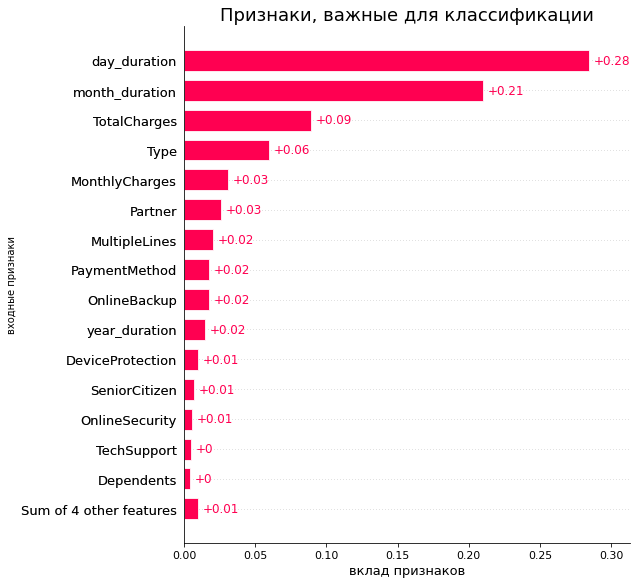

In [84]:
fig, ax = plt.subplots()

shap.plots.bar(shap_values[:,:,1], max_display=16, show=False) 
ax.set_xlabel('вклад признаков')
ax.set_ylabel('входные признаки')
ax.set_title('Признаки, важные для классификации', fontsize=18)

Определяющим фактором в поиске клиентов,склонных разорвать контракт с компанией, является длительность договора.

Кроме того, не последнюю роль в определении класса клиента играют тип оплаты (помесячно, ежегодно, раз в два года), расходы, наличие партнера.


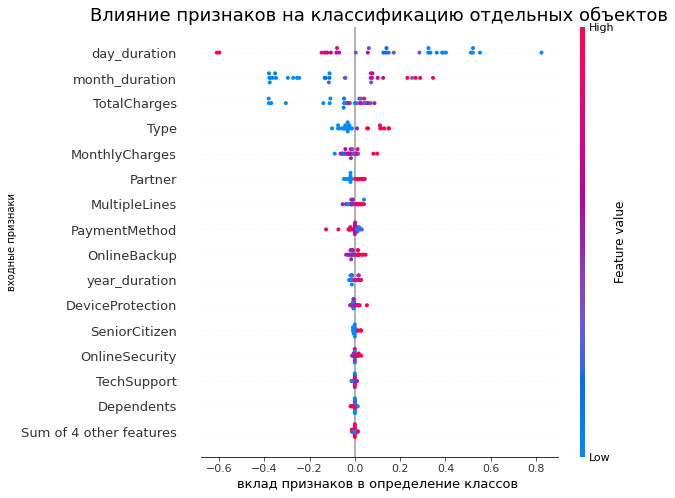

In [85]:
fig, ax = plt.subplots()

shap.plots.beeswarm(shap_values[:,:,1], max_display=16, show=False) 
ax.set_xlabel('вклад признаков в определение классов ')
ax.set_ylabel('входные признаки')
ax.set_title('Влияние признаков на классификацию отдельных объектов', fontsize=18);

Клиент склонен разорвать договор с компанией, если:
- это "старый" клиент. Вероятно, т.к. компания не дает привелегии для лояльных клиентов, такой клиент перестает пользоваться невыгодной услугой. Может перейти к другому оператору, который предлагает бонусы новым клиентам.
- в тоже время это могут быть и новые клиенты. Видимо таким клиентам тоже оператор дает недостаточно выгодное предложение.
- клиенты с оплатой раз в год, раз в два года. Может быть, такой тип оплаты в целом не очень перспективный, т.к. в связи с довольно быстрым темпом развития цифровых услуг, услуги в течение 1-2 лет могут устаревать (например, скорость интернета), а клиент должен ждать следующего периода оплаты, чтоб что-то поменять или оказывается в другой подобной невыгодной ситуации.
- семейный клиенты. Такие клиенты могут жестче контролировать свои расходы, поэтому могут уйти от оператора к более выгодному.


## 5.5 Вывод по обучению

Для решения задачи предсказания оттока клиентов из компании провели подготовку данных через пайплайн. Использовали масштабирование для числовых признаков и OHE кодирование для категориальных признаков. Кодировали таргет  (признак `left`, ушел клиент или остался) с помощью LabelEncoder.

Относительно хороший результат показала базовая логичестическая регрессия. Значения ROC-AUC при кросс-валидации: 0.768. Точность модель при кросвалидации: 0.862. В результате подбора гиперпараметров (коэффициента регуляризации) качество не улучшилось.

За счет использования нелинейной модели - модели градиентного бустинга lightgbm - и изменения признаков используемых при обучении удалось достичь желаемого качества модели. Для обучения использовали, все данные, кроме пола клиентов, дат начала и окончания договора. В том числе использовали созданные признаки длительности договора (в днях, месяцах и годах), что помогло значительно повысить метрику качества.

Лучшая модель - **LGBMClassifier со скоростью обучения 0.25,  глубиной деревьев 3, 140 моделями в ансамбле.** 

Результат качества модели на тестовой выборке: ROC-AUC 0.896, точность (accuracy) 0.897. Значение точности показывает, что 9 из 10 клиентов модель классифицирует верно.

Согласно матрице ошибок:
- Из 1603 клиентов оставшихся у оператора  модель правильно предсказала класс 1454 клиентов, а 149 клиентов модель неверно отнесла к классу ушедших.
- Из 158 клиентов ушедших от оператора модель правильно предсказала класс 126 клиентов, а 32 клиентов модель неверно отнесла к классу оставшихся.
- Precision равно 80%: С вероятность 20% модель дает ложноположителный результат - то есть ошибется и предскажет что клиент уходит, хотя он не собирался.
- Recall равен 46 %: Модель в половине случаев может ошибаться и неверно относить собирающегося разорвать договор клиента к классу лояльных клиентов.

Согласно анализу важности признаков:

- Определяющим фактором в поиске клиентов,склонных разорвать контракт с компанией, является длительность договора.
- Кроме того, не последнюю роль в определении класса клиента играют тип оплаты (помесячно, ежегодно, раз в два года), расходы, наличие партнера.

Клиент склонен разорвать договор с компанией, если:
- это "старый" клиент. Вероятно, компания не дает привелегии для лояльных клиентов

- в тоже время это могут быть и новые клиенты. Видимо таким клиентам тоже оператор дает недостаточно выгодное предложение.

- клиенты с оплатой раз в год, раз в два года. 

- семейный клиенты. Такие клиенты могут жестче контролировать свои расходы, поэтому могут уйти от оператора к более выгодному.




# 6. Итоговый вывод

1. **Обзор данных:**
- Информация для исследования представлена в 4 таблицах (данные договоров, персональные данные клиентов, информация о интернет услугах и услугах телефонии). Данные соответствуют описанию задачи.
- Всего для исследования предоставлены данные 7043 клиентов компании, некоторые пользуются только интернет услугами, другие - услугами телефонии.
- Есть клиенты, которые только начали пользоваться услугами компании - договор от 1 февраля 2020 (дата выгрузки данных).

2. **Предобработка данных:**
- Обнаружено небольшое количество пропусков в таблице с контрактами в колонке общих расходов.Пропуски характерные для клиентов, которые только оформили договор и еще ничего не заплатили. Таких записей 11 штук. Пропуски преобразовали в нули.
- Дубликатов не обнаружено.
- Изменила тип данных колонки, является ли клиент пенсионером, - на категориальный тип; колонки общих расходов - на вещественный числовой.
- Добавила целевой признак (1 - клиент ушел, 0 - клиент остался), а также вспомогателные признаки с длительностью контракта (в годах, в днях и в месяцах) для всех клиентов.

3. **Предварительный разведочный анализ:**
- Для работы предоставлены данные по клиентам которые пришли в компанию с 2013 по 2020 годы. При этом больше всего клиентов пришло в 2019 и 2014 году.
- Много относительно новых клиентов - в компании около 10-20 недель. Есть локальный максимум "старых" клиентов - пользуются услугами компании около 70 месяцев (более пяти лет).

- "Усредненного" клиента можно описать так:
    - небольшое количество подключенных услуг, отсюда небольшие месячные расходы
    - оплачивает услуги компании ежемесячно, оплата по электронному расчетному листу или подключен автоплатеж
    - моложе пенсионного возраста, без детей
    - если пользуется интернет услугами, то подключение через оптоволокно, вероятно подключены доп услуги (стриминговое ТВ и  др).

- В датасете присутствует дисбаланс по целевому классу: только 16% от всех клиентов перестали пользоваться услугами компании. Это умеренный дисбаланс, ничего предпринимать для его устранения не будем (кроме того, что учтем это при разбиении выборок).

- При отдельном рассмотрении ушедших клиентов видим, что:
    - большая их часть стала клиентами компании в 2014-2015 гг
    - покидали компанию в основном в 2018-2019 гг
    - разрывали контракт после 1-3 лет пользования услугами оператора

4. **Объединение таблиц и разведочный анализ:** 
- Все четыре таблицы соединили в одну по идентификатору клиента.

- Проанализировали данные по группам (ушел / не ушел клиент):

    a. Расходы ушедших клиентов слегка выше, чем у оставшихся. Вероятно из-за того, что среди не расторгнувших договор достаточно много новых клиентов, которые пришли меньше года назад, а среди ушедших, наоборот, много "старых" клиентов.

    b. Различия "портретов" ушедшего клиента и оставшегося клиента компании:

    - Более половины ушедших клиентов состоят в браке ( среди оставшихся - больше одиноких) 
    - Ушедшие клиенты относительно меньше пользовались расчетом по почте нежеди действующие клиенты.
    - Ушедшие клиенты активнее пользовались доп интернет услугами (облако, антивирус, стриминговое тв, каталог фильмов)
    - Ушедшие клиенты активнее пользовались услугой подключения нескольких телефонных линий

- Анализ корреляций показал, что:
    - С целевым признаком остальные признаки коррелируют умеренно или слабо. 
    - Все интернет услуги сильно коррелируют друг с другом - мультиколлинеарны.
    - Пол клиента никак не связан с остальными признаками (стоит убрать дальше из исследования).
    - Расходы коррелируют с наличием подключенных услуг: очевидно, чем больше подключено услуг, тем больше расходы клиента.

5. **Обучение моделей**

Для решения задачи предсказания оттока клиентов из компании провели подготовку данных через пайплайн. Использовали масштабирование для числовых признаков и OHE кодирование для категориальных признаков. Кодировали таргет  (признак `left`, ушел клиент или остался) с помощью LabelEncoder.

За счет использования нелинейной модели - модели градиентного бустинга lightgbm - и изменения признаков используемых при обучении удалось достичь желаемого качества модели. Для обучения использовали, все данные, кроме пола клиентов, дат начала и окончания договора. В том числе использовали созданные признаки длительности договора (в днях, месяцах и годах), что помогло значительно повысить метрику качества.

Лучшая модель - **LGBMClassifier со скоростью обучения 0.25,  глубиной деревьев 3, 140 моделями в ансамбле.** 

Результат качества модели на тестовой выборке: ROC-AUC 0.896, точность (accuracy) 0.897. Значение точности показывает, что 9 из 10 клиентов модель классифицирует верно.

Согласно матрице ошибок:
- Из 1603 клиентов оставшихся у оператора  модель правильно предсказала класс 1454 клиентов, а 149 клиентов модель неверно отнесла к классу ушедших.
- Из 158 клиентов ушедших от оператора модель правильно предсказала класс 126 клиентов, а 32 клиентов модель неверно отнесла к классу оставшихся.
- С вероятность 20% модель дает ложноположителный результат - то есть ошибется и предскажет что клиент уходит, хотя он не собирался.
- Модель в половине случаев может ошибаться и неверно относить собирающегося разорвать договор клиента к классу лояльных клиентов.


Согласно анализу важности признаков:

- Определяющим фактором в поиске клиентов,склонных разорвать контракт с компанией, является длительность договора.
- Кроме того, не последнюю роль в определении класса клиента играют тип оплаты (помесячно, ежегодно, раз в два года), расходы, наличие партнера.

Клиент склонен разорвать договор с компанией, если:
- это "старый" клиент. Вероятно, т.к. компания не дает привелегии для лояльных клиентов, такой клиент перестает пользоваться невыгодной услугой. Может перейти к другому оператору, который предлагает бонусы новым клиентам.
- в тоже время это могут быть и новые клиенты. Видимо таким клиентам тоже оператор дает недостаточно выгодное предложение.
- клиенты с оплатой раз в год, раз в два года. Может быть, такой тип оплаты в целом не очень перспективный, т.к. в связи с довольно быстрым темпом развития цифровых услуг, услуги в течение 1-2 лет могут устаревать (например, скорость интернета), а клиент должен ждать следующего периода оплаты, чтоб что-то поменять или оказывается в другой подобной невыгодной ситуации.
- семейный клиенты. Такие клиенты могут жестче контролировать свои расходы, поэтому могут уйти от оператора к более выгодному.



**Таким образом,** наиболее важным признаком на который нужно обратить внимание для удержания клиентов - это длительность договора. Особого внимания требуют как "старые" клиенты, так и новые. Различные бонусы и промокоды помогут сделать пользование услугами оператора более выгодным и они с меньшей вероятностью уйдут к конкурентам. Полученная в работе модель довольно точно на основе имеющихся данных поможет предсказать склонность клиента разорвать договор (ошибочно относит к желающих расторгнуть контракт к лояльным клиентам в 20% случаев).

**Рекомендации:**
- предлагать промокоды и различные бонусы клиентам:
    - которых модель классифицировала как склонных к уходу
    - лояльным клиентам, которые более двух лет пользуются услугами компании
    - новым клиентам, которые пользуются услугами пару месяцев
- вероятно, убрать режими оплаты раз в год и раз в два года
- разработать выгодные предложения для семейных клиентов
